<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Python/blob/master/Keras/Laboratorio_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




# Objetivos

*   Aplicar procedimiento de data augmentation a un conjunto de imagenes.
*   Construir un clasificador de imagenes a partir de una red neuronal convolucional (CNN).
*   Construir un clasificador de imagenes utilizando la tecnica de transfer learning.
*   Construir una red neuronal de tipo autoencoder para la eliminación de ruido en imagenes.



# Convolutional Neural Networks (CNN)


### 0. Configuración Inicial

##### 0.1 Montando unidad de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 0.2 Validando la configuración CPU/GPU

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14605362686851166665
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9167636083197574786
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11831312043032685603
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2523522546527034574
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [ ]:
!nvidia-smi

Sun Jul 19 21:54:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    40W / 250W |    353MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
import pandas as pd
import numpy as np
import sys
import random
from pandas_profiling import ProfileReport

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Perfilamiento y entendimiento de los datos



#### Descarga de los datos
Primero, se descargan los datos y se visualizan que se hayan leido correctamente.

In [ ]:
!wget -O cnn_data.zip "https://drive.google.com/drive/u/1/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n"

--2020-07-20 18:50:52--  https://drive.google.com/drive/u/1/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n
Resolving drive.google.com (drive.google.com)... 64.233.166.113, 64.233.166.100, 64.233.166.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.166.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/drive/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n [following]
--2020-07-20 18:50:53--  https://drive.google.com/drive/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https://drive.google.com/drive/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n&followup=https://drive.google.com/drive/folders/1NGjqrgNCBmozpuuZJr2HFG14mtCVPR2n [following]
--2020-07-20 18:50:53--  https://accounts.google.com/ServiceLogin?service=wise&passive=1209600&continue=https:/

Se define los datos de entrenamiento y validación:

In [ ]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/data/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/data/validation'

Un ejemplo de las imagenes descargas se present a continuación:

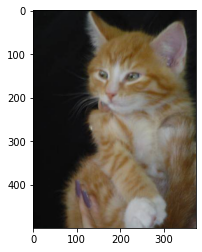

In [ ]:
img = load_img('/content/drive/My Drive/Colab Notebooks/data/train/cat/cat.39.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

### 3. Preparación de datos

#### 3.1 Data augmentation

Data augmentation es una técnica utilizada para extender el conjunto de datos de entrenamiento y test y así garantizar un mejor nivel de generalización y disminuir las posibilidades de un sobre ajuste.

La técnica básicamente consiste en la realización de transformaciones sobre unas imágenes en aspectos como: rotaciones, traslaciones, cambios de escala, etc.


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

A continuación se muestra un ejemplo de las salidas generadas a partir de la función *ImageDataGenerator*. El comando .flow () a continuación genera lotes de imágenes transformadas al azar y guarda los resultados en el directorio 'preview /'.

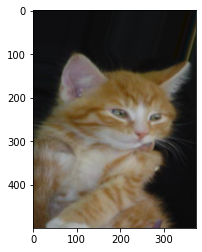

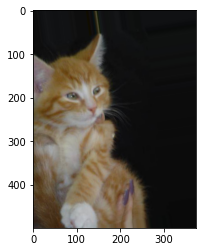

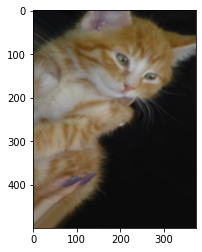

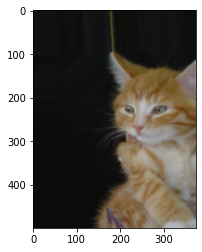

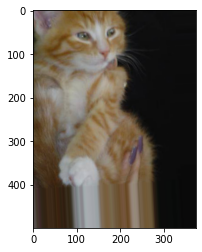

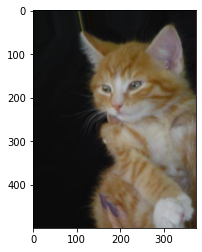

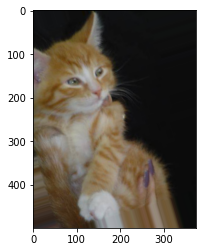

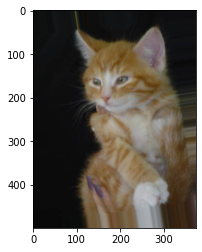

In [ ]:
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)
i = 0

for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely
    plt.imshow(batch[0]/255) 
    plt.show()

In [ ]:
# Dataset configuration
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 256

Realización de data augmentation en dos pasos:
1. Configuración de los parametros para la aumentación de datos.
2. Parametrización de directorio de entrada, tamaño de las imagenes de salida, tamaño del bach a generar, etc.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size= batch_size,
    class_mode='binary')

steps_per_epoch = train_generator.n

Found 2000 images belonging to 2 classes.


Realización de data augmentation sobre los datos de prueba:

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary')

validation_steps = validation_generator.n

Found 401 images belonging to 2 classes.


### 4. Modelamiento


Configuración de hiperparametros:

In [ ]:
# Hyperparameters
epochs = 25
loss = 'binary_crossentropy'
optimizer='rmsprop'
metrics=['accuracy']

#### 4.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura de Convolutional Network estructurada de la siguiente manera:

![Multilayer Perceptron](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/CNN.png?raw=true)

Las CNN cuentan con celdas de convolución (o capas de agrupación) y núcleos, cada uno con un propósito diferente. 

Los núcleos de convolución en realidad procesan datos de entrada, y las capas de agrupación los simplifican (principalmente utilizando funciones no lineales, como max), reduciendo características innecesarias. 

Las CNN típicamente son utilizadas para el reconocimiento de imágenes. La ventana de entrada se desliza a lo largo de la imagen, píxel por píxel. Los datos se pasan a capas de convolución, que forman un embudo (compresión de características detectadas). 

A partir de los términos de reconocimiento de imagen, la primera capa detecta gradientes, la segunda líneas, la tercera formas, etc. a la escala de objetos particulares. 

Las CNN comúnmente se unen a la capa convolucional final para el procesamiento de datos adicional.

**Pendiente: **Dibujar arquitectura http://alexlenail.me/NN-SVG/LeNet.html

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

Y se 'compila', para poder entrenar los parámetros del modelo.

In [ ]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples, // batch_size
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs
    )

'model.fit_generator(\n    train_generator,\n    validation_data = validation_generator,\n    validation_steps = nb_validation_samples, // batch_size\n    steps_per_epoch = nb_train_samples // batch_size,\n    epochs = epochs\n    )'

#### 4.2 Transfer Learning

![transfer](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/transfer.png?raw=true)

Para este laboratorio se utilizará MobileNet para realizar el proceso de transfer learning. Algunos de los modelos que se pueden utilizar se pueden consultar en el siguiente enlace: [Transfer Learning](https://keras.io/api/applications/)

* VGG
* ResNet
* Inception
* MobileNet
* DenseNet
* Xception

In [ ]:
# build the MobileNet network
model_MobileNetV2 = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

NameError: ignored

In [ ]:
model_MobileNetV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
def create_model():
    model = Sequential([
        model_MobileNetV2,
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    return model

model_transfer = create_model()
model_transfer.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 1280)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 5, 5, 1)           1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model_transfer.fit_generator(train_generator,
                             validation_data = validation_generator,
                             validation_steps = validation_steps, 
                             steps_per_epoch = steps_per_epoch,
                             epochs = epochs
                             )

'''model_transfer.fit(train_data, 
            train_labels,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(validation_data, validation_labels))
            
model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=1
)
'''

Epoch 1/25


ValueError: ignored

### 5. Predicción

In [ ]:
for x_batch, y_batch in validation_generator:
  plt.imshow(x_batch[0])
  print(y_batch)
  print(model.predict_proba(x_batch))
  break

Comparemos los dos modelos, el que construimos con los valores dados, y el que encontramos a través de la entonación de hiperparámetros.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(score[0], score[1]))

In [ ]:
print(model.predict(X_test))
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred

In [ ]:
print(best_model.predict(Xtext_test))
y_pred_text = best_model.predict(Xtext_test)
y_pred_text

### 6. Validación

In [ ]:
Y_test = y_test.argmax(axis=-1)
print('Reporte para el modelo construido')
print(classification_report(Y_test, y_pred, target_names=y.columns))
print('Reporte para el modelo entonado')
print(classification_report(Y_test, y_pred_text, target_names=y.columns))

In [ ]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_text)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=y.columns,
            yticklabels=y.columns)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Autoencoders for image denoising

## 0. Descarga de los datos
Primero, se descargan los datos y se visualizan que se hayan leido correctamente.

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## 1. Perfilamiento y entendimiento de los datos

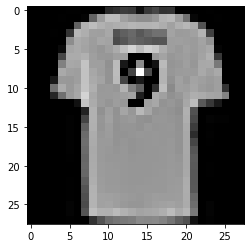

In [ ]:
i = random.randint(1,60000) # select any random index from 1 to 60,000
plt.imshow(X_train[i] , cmap = 'gray') # reshape and plot the image

In [ ]:
label = y_train[i]
label

0

## 2. Preparación de datos

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

Se agrega ruido a los datos:

In [ ]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [ ]:
X_train_noise = noising_image(X_train, 0.3)
X_test_noise = noising_image(X_test, 0.3)

In [ ]:
print(X_train_noise.shape)
print(X_test_noise.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualizamos como es el resultado de agregar ruido a una de las imagenes:

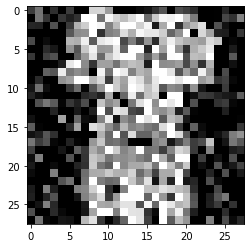

In [ ]:
plt.imshow(X_train_noise[10], cmap="gray")

## 3. Modelamiento

### 3.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura de Autoencoder estructurada de la siguiente manera:

![Autoencoder](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Autoencoder.png?raw=true)

Los codificadores automáticos o autoencoders se utilizan para la clasificación, agrupamiento y compresión de características.

Los autoencoders, por otro lado, pueden ser entrenados sin supervisión. Su estructura generalmente se caracteriza por: 
1. La cantidad de neuronas ocultas es menor que la cantidad de celdas de entrada.
2. La cantidad de celdas de salida es igual a la cantidad de celdas de entrada.
3. El autoencoder se entrena de manera en que la salida está lo más cerca posible de la entrada, obligando a los autoencoders a generalizar datos y realizar búsqueda de patrones comunes.

In [ ]:
autoencoder = Sequential()

#Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

In [ ]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(X_train_noise.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=10, 
                batch_size=200, 
                validation_data=(
                    X_test_noise.reshape(-1, 28, 28, 1), 
                    X_test.reshape(-1, 28, 28, 1)
                    )
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.3968 - val_loss: 0.3237
Epoch 2/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3148 - val_loss: 0.3128
Epoch 3/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3082 - val_loss: 0.3088
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3053 - val_loss: 0.3067
Epoch 5/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.3037 - val_loss: 0.3054
Epoch 6/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.3026 - val_loss: 0.3044
Epoch 7/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3017 - val_loss: 0.3037
Epoch 8/10
60000/60000 [==============================] - 2s 27us/step - loss: 0.3010 - val_loss: 0.3031
Epoch 9/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.3006 - val_loss: 0.3028
Epoch

## 4. Predicción

In [ ]:
predicted = autoencoder.predict(X_test_noise[:10].reshape(-1, 28, 28, 1))

## 6. Validación

In [ ]:
evaluation = autoencoder.evaluate(X_test_noise.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Accuracy : {:.3f}'.format(evaluation))

10000/10000 [==============================] - 1s 64us/step
Test Accuracy : 0.302


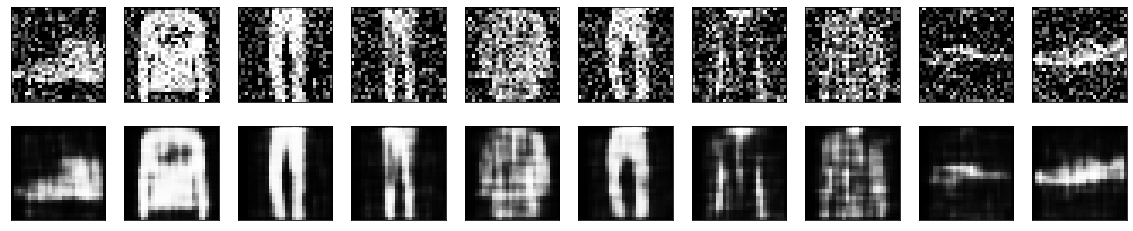

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Taller
## Segundo Problema


Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.
